Step 1: Import necessary libraries and load the dataset

In [1]:
import cv2
import tensorflow as tf
from tensorflow import keras
import glob,os
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from skimage.feature import hog
from skimage.color import rgb2gray
from skimage.filters import gaussian
from sklearn.preprocessing import StandardScaler
import os
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import  LabelBinarizer


In [2]:
IMAGE_SIZE = 224
BATCH_SIZE= 32
CHANNELS= 3
EPOCHS=10

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

# Load dataset
dataset= tf.keras.preprocessing.image_dataset_from_directory(
    "gaussian_filtered_images/gaussian_filtered_images",
    shuffle= True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size= BATCH_SIZE
)

Found 3662 files belonging to 5 classes.


In [4]:
class_names= dataset.class_names
class_names

['Mild', 'Moderate', 'No_DR', 'Proliferate_DR', 'Severe']

In [5]:
for image_batch, label_batch in dataset.take(1):
   print (image_batch. shape)
   print(label_batch.numpy())

(32, 224, 224, 3)
[2 2 1 2 2 3 1 2 2 2 2 2 2 2 2 2 2 1 1 2 2 2 2 1 2 1 1 3 2 0 4 3]


In [6]:
mild_path=glob.glob(r'gaussian_filtered_images/Mild/*.png')
moderate_path=glob.glob(r'gaussian_filtered_images/Moderate/*.png')
proliferate_dr_path=glob.glob(r'gaussian_filtered_images/No_DR/*.png')
no_dr=glob.glob(r'gaussian_filtered_images/Proliferate_DR/*.png')
severe_path=glob.glob(r'gaussian_filtered_images/Severe/*.png')

In [7]:
mild_dir=[]
moderate_dir=[]
no_dr_dir=[]
proliferate_dr_dir=[]
severe_dir=[]
for i in mild_path:
    img=cv2.imread(i,1)
    img=cv2.resize(img,(128,128))
    img=img/255
    mild_dir.append(img)
for i in moderate_path:
    img=cv2.imread(i,1)
    img=cv2.resize(img,(128,128))
    img=img/255
    moderate_dir.append(img)
for i in proliferate_dr_path:
    img=cv2.imread(i,1)
    img=cv2.resize(img,(128,128))
    img=img/255
    proliferate_dr_dir.append(img)
for i in no_dr:
    img=cv2.imread(i,1)
    img=cv2.resize(img,(128,128))
    img=img/255
    no_dr_dir.append(img)
for i in severe_path:
    img=cv2.imread(i,1)
    img=cv2.resize(img,(128,128))
    img=img/255
    severe_dir.append(img)

In [8]:
def data_import(mild_dir,moderate_dir,proliferate_dr_dir,severe_dir, no_dr):
    df_data_mild = pd.DataFrame({'image':mild_dir, 'label': 'mild'})
    df_data_moderate = pd.DataFrame({'image':moderate_dir, 'label': 'moderate'})
    df_data_no = pd.DataFrame({'image':no_dr_dir, 'label': 'no_DR'})
    df_data_proliferate = pd.DataFrame({'image':proliferate_dr_dir, 'label': 'proliferate_DR'})
    df_data_severe = pd.DataFrame({'image':severe_dir, 'label': 'severe'})

    
    final_data = [df_data_mild, df_data_moderate,df_data_proliferate,df_data_severe, df_data_no_dr]
    final_data = pd.concat(final_data)
    
    all_data = final_data['image']
    labels = final_data['label']
    all_data=np.stack(all_data,axis=0)
    labels = LabelBinarizer().fit_transform(labels)
    return all_data,labels

C:\Users\panch\AppData\Local\Temp\ipykernel_12796\3431994333.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(3, 4, i + 1)


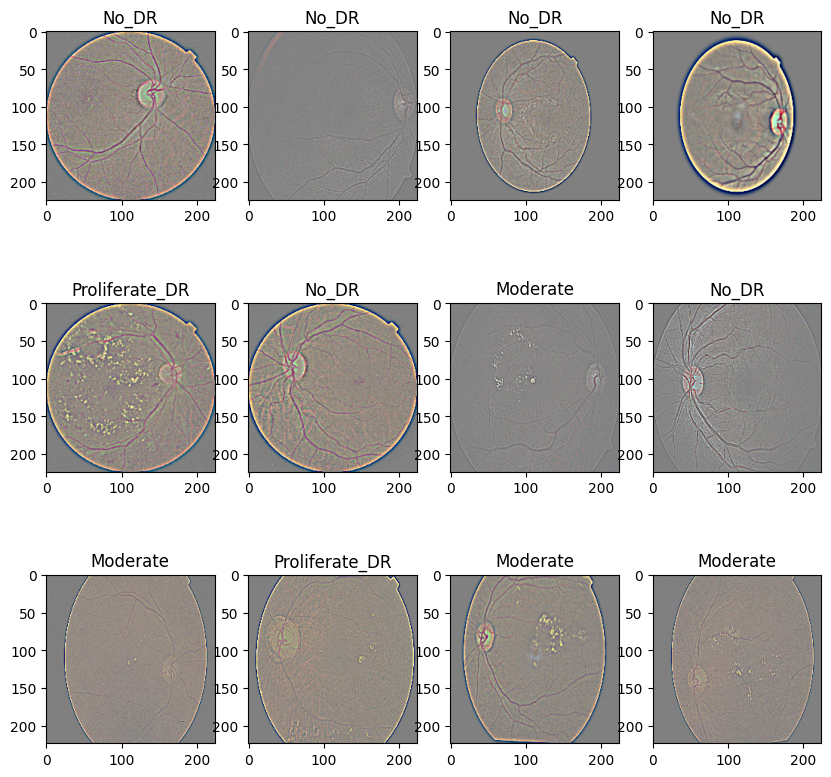

In [9]:
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])

In [10]:
len(dataset)

115

In [11]:
num_sample_images = 1
image_dict = {}
for i, folder in enumerate(class_names):
    image_dict[folder.split("/")[-1].split()[0]] = glob.glob(str(dataset) + ".jpg")[:num_sample_images]

In [12]:
def to_grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def threshold_image(img, thresh_min=155, thresh_max=255):
    return cv2.threshold(img, thresh_min, thresh_max, cv2.THRESH_BINARY)[1]

def getContours(image):
    contours, hierarchy = cv2.findContours(image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    return (contours, hierarchy)

def drawContours(image, contours):
    return cv2.drawContours(image, contours, -1, (255, 0, 0), 0)

def calculateImageFeatures(contours, featcols):
    feat_array = np.zeros((1, len(featcols)), np.float32)
    mmnts =  cv2.moments(contours[0], False)
    for i, k in enumerate(sorted(mmnts.keys())):
        feat_array[0, i] = mmnts[k]
    
    area = cv2.contourArea(contours[0], False)
    
    centroid_x = mmnts['m10']/(mmnts['m00'] + 0.000000000001)
    centroid_y = mmnts['m01']/(mmnts['m00'] + + 0.000000000001)
    arcLength = cv2.arcLength(contours[0], True)
    
    feat_array[0, len(mmnts)] = area
    feat_array[0, len(mmnts)+1] = centroid_x
    feat_array[0, len(mmnts)+2] = centroid_y
    feat_array[0, len(mmnts)+3] = arcLength
    
    return feat_array

In [13]:
# Load dataset
data_dir = 'gaussian_filtered_images/gaussian_filtered_images'
classes = ['No_DR', 'Mild', 'Moderate', 'Severe', 'Proliferate_DR']
data = []
for label in classes:
    path = os.path.join(data_dir, label)
    class_num = classes.index(label)
    for img in os.listdir(path):
        try:
            img_arr = np.array(Image.open(os.path.join(path, img)))
            img_arr = rgb2gray(img_arr)
            img_arr = gaussian(img_arr, sigma=1)
            img_arr = hog(img_arr, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), visualize=False)
            data.append([img_arr, class_num])
        except Exception as e:
            pass


In [14]:
# Create feature matrix and target vector
X = []
y = []
for features, label in data:
    X.append(features)
    y.append(label)
X = np.array(X)
y = np.array(y)

In [15]:
# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

Step 2: Split the dataset into training and testing sets

In [16]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Step 3: Flatten the images into 1D arrays

In [17]:
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)


Step 4: Train the KNN model

In [18]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_flat, y_train)

KNeighborsClassifier()

Step 5: Evaluate the model on the testing set

In [19]:
test_acc = knn.score(X_test_flat, y_test)
print('Test accuracy:', test_acc)


Test accuracy: 0.6657571623465212


In [20]:
y_pred = knn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: ", accuracy)

Accuracy:  0.6657571623465212


Accuracy: 0.6657571623465212


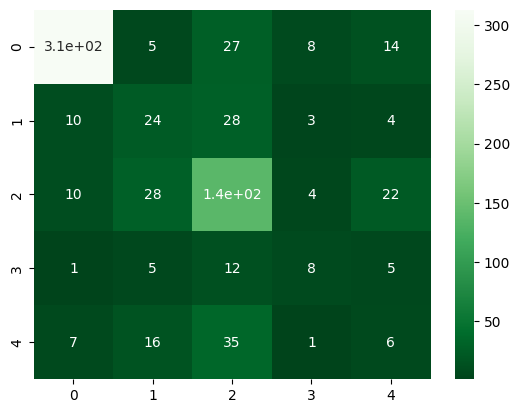

In [21]:
# Calculate accuracy score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap = "Greens_r")
plt.show()